In [1]:
import os
import cv2
import random
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps
import nibabel as nib
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
#from tensorflow.keras.layers.experimental import preprocessing

In [2]:
scaler = MinMaxScaler()

In [3]:
TRAIN_DATASET_PATH = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
TRAIN_DATASET_PATH2 = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"


In [4]:
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x
train_and_val_directories1 = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
train_and_test_ids1 = pathListIntoIds(train_and_val_directories1);

train_test_ids1, val_ids1 = train_test_split(train_and_test_ids1,test_size=0.2)
train_ids1, test_ids1 = train_test_split(train_test_ids1,test_size=0.15)

train_and_val_directories2 = [f.path for f in os.scandir(TRAIN_DATASET_PATH2) if f.is_dir()]


train_and_test_ids2 = pathListIntoIds(train_and_val_directories2);

train_test_ids2, val_ids2 = train_test_split(train_and_test_ids2,test_size=0.2)
train_ids2, test_ids2 = train_test_split(train_test_ids2,test_size=0.15)

In [5]:
# Define seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3
}

# Select Slices and Image Size
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE=128

In [6]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
import nibabel as nib  # Assuming nibabel is used to load .nii files

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(128, 128), batch_size=1, n_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim  # Ensuring 128x128 as requested
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels), dtype=np.float32)
        y = np.zeros((self.batch_size * VOLUME_SLICES, 128, 128), dtype=np.float32)
        Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4), dtype=np.float32)

        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            flair_path = os.path.join(case_path, f'{i}_flair.nii')
            flair = nib.load(flair_path).get_fdata()

            t1ce_path = os.path.join(case_path, f'{i}_t1ce.nii')
            t1ce = nib.load(t1ce_path).get_fdata()

            # Load segmentation file: check if file exists
            seg_path = os.path.join(case_path, f'{i}_seg.nii')
            if os.path.exists(seg_path):
                seg = nib.load(seg_path).get_fdata()
            else:
                fallback_seg_path = os.path.join(case_path, 'W39_1998.09.19_Segm.nii')
                if os.path.exists(fallback_seg_path):
                    seg = nib.load(fallback_seg_path).get_fdata()
                else:
                    raise FileNotFoundError(f"Neither '{seg_path}' nor '{fallback_seg_path}' found for ID '{i}'.")

            # Resize and store the images in the batch
            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], self.dim)
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], self.dim)

                # Resizing segmentation masks
                y[j + VOLUME_SLICES * c] = cv2.resize(seg[:, :, j + VOLUME_START_AT], self.dim)

        # Adjust mask values and one-hot encode
        y[y == 4] = 3  # Custom logic for mask values
        mask = tf.one_hot(y.astype(np.int32), 4)  # One-hot encode

        # Resize the mask to match dimensions if needed
        Y = tf.image.resize(mask, self.dim)

        # Normalize each image in X individually (scale to [0, 1])
        X = X / 255.0

        return X, Y


In [7]:
class TIFDataGenerator(keras.utils.Sequence):
    'Generates data for Keras from TIF images'
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size, *self.dim, self.n_channels))  # Shape: (batch_size, IMG_SIZE, IMG_SIZE, n_channels)
        y = np.zeros((self.batch_size, *self.dim))  # Shape: (batch_size, IMG_SIZE, IMG_SIZE)

        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH2, i)

            for index in range(1, 21):  # Assuming 20 images per case
                img_path = os.path.join(case_path, f'{i}_{index}.tif')
                mask_path = os.path.join(case_path, f'{i}_{index}_mask.tif')

                # Check if TIF files exist
                if not (os.path.exists(img_path) and os.path.exists(mask_path)):
                    raise FileNotFoundError(f"One or more files not found for ID '{i}' at index {index}.")

                # Load images
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale

                # Resize images to target dimensions
                img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                mask_resized = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

                # Store the images in the batch
                X[c, :, :, 0] = img_resized  # Assuming first channel is the image
                X[c, :, :, 1] = img_resized  # Adjust as needed for multiple channels

                # Create a binary mask (or one-hot encoded mask if needed)
                y[c] = mask_resized  # Update as necessary based on how you want to process segmentation

        # Generate masks (if using one-hot encoding, adjust as necessary)
        y[y == 4] = 3  # Modify segmentation as per your original logic
        mask = tf.one_hot(y, 4)  # One-hot encode the mask
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))

        return X / np.max(X), Y  # Normalize X to [0,1]




In [8]:
class CombinedDataGenerator(keras.utils.Sequence):
    'Generates data for Keras from both DataGenerator and TIFDataGenerator'
    
    def __init__(self, data_gen_1, data_gen_2):
        'Initialization'
        self.data_gen_1 = data_gen_1
        self.data_gen_2 = data_gen_2
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return max(len(self.data_gen_1), len(self.data_gen_2))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Get data from the first generator
        if index < len(self.data_gen_1):
            X1, y1 = self.data_gen_1[index]
        else:
            X1, y1 = None, None  # Or handle this case as needed

        # Get data from the second generator
        if index < len(self.data_gen_2):
            X2, y2 = self.data_gen_2[index]
        else:
            X2, y2 = None, None  # Or handle this case as needed

        # Concatenate the results
        if X1 is not None and X2 is not None:
            X = np.concatenate((X1, X2), axis=0)  # Concatenate along the first axis
            y = np.concatenate((y1, y2), axis=0)  # Concatenate along the first axis
        elif X1 is not None:
            X, y = X1, y1
        elif X2 is not None:
            X, y = X2, y2
        else:
            X, y = None, None  # Handle case where both are None

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.data_gen_1.on_epoch_end()
        self.data_gen_2.on_epoch_end()

In [9]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Dice coefficient for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    total_loss = 0.0  # Initialize total_loss outside the loop
    for i in range(class_num):
        # Use tf.keras.backend.flatten instead of K.flatten
        y_true_f = tf.keras.backend.flatten(y_true[:, :, :, i])
        y_pred_f = tf.keras.backend.flatten(y_pred[:, :, :, i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        total_loss += loss  # Accumulate the loss
    return total_loss / class_num  # Return the mean Dice coefficient

# Precision metric
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

# Sensitivity metric
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Specificity metric
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# Dice coefficient for necrotic tissue
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:, :, :, 1] * y_pred[:, :, :, 1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:, :, :, 1])) + K.sum(K.square(y_pred[:, :, :, 1])) + epsilon)

# Dice coefficient for edema
def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:, :, :, 2] * y_pred[:, :, :, 2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:, :, :, 2])) + K.sum(K.square(y_pred[:, :, :, 2])) + epsilon)

# Dice coefficient for enhancing tumor
def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:, :, :, 3] * y_pred[:, :, :, 3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:, :, :, 3])) + K.sum(K.square(y_pred[:, :, :, 3])) + epsilon)


In [10]:

def build_unet(inputs, ker_init, dropout):
    inputs = Input(shape=(128, 128, 2))
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool)
    conv = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(drop5))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv9)

    up = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv9))
    merge = concatenate([conv1, up], axis=3)
    conv = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge)
    conv = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv)

    conv10 = Conv2D(4, (1, 1), activation='softmax')(conv)

    return Model(inputs=inputs, outputs=conv10)


In [11]:
training_generator1 = DataGenerator(train_ids1)
valid_generator1 = DataGenerator(val_ids1)
test_generator1 = DataGenerator(test_ids1)

training_generator2 = TIFDataGenerator(train_ids2)
valid_generator2 = TIFDataGenerator(val_ids2)
test_generator2 = TIFDataGenerator(test_ids2)

training_generator = CombinedDataGenerator(training_generator1, training_generator2)
valid_generator = CombinedDataGenerator(training_generator1, training_generator2)
test_generator = CombinedDataGenerator(training_generator1, training_generator2)


In [12]:
callbacks = [
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                            patience=2, min_lr=0.000001, verbose=1),
      keras.callbacks.ModelCheckpoint(filepath = '/kaggle/working/model.weights.h5',
                          verbose=1, save_best_only=True, save_weights_only = True),
      CSVLogger('/kaggle/working/training.log', separator=',', append=False)
    ]

In [13]:
import gc
gc.collect()

0

In [14]:
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing])

In [15]:
K.clear_session()

history =  model.fit(training_generator,
                    epochs=30,
                    steps_per_epoch=len(train_ids1+train_ids2),
                    callbacks= callbacks,
                    validation_data = valid_generator
                    )

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728851571.686596      64 service.cc:145] XLA service 0x7e804c003790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728851571.686661      64 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1728851599.582537      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/324 ━━━━━━━━━━━━━━━━━━━━ 53s 728ms/step - accuracy: 0.9578 - dice_coef: 0.2462 - dice_coef_edema: 0.0789 - dice_coef_enhancing: 0.0261 - dice_coef_necrotic: 0.0484 - loss: 0.4031 - mean_io_u: 0.4827 - precision: 0.9572 - sensitivity: 0.9198 - specificity: 0.9906

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_loss improved from inf to 0.08640, saving model to /kaggle/working/model.weights.h5
324/324 ━━━━━━━━━━━━━━━━━━━━ 272s 717ms/step - accuracy: 0.9627 - dice_coef: 0.2496 - dice_coef_edema: 0.0860 - dice_coef_enhancing: 0.0278 - dice_coef_necrotic: 0.0514 - loss: 0.3554 - mean_io_u: 0.4851 - precision: 0.9622 - sensitivity: 0.9302 - specificity: 0.9914 - val_accuracy: 0.9811 - val_dice_coef: 0.2836 - val_dice_coef_edema: 0.1695 - val_dice_coef_enhancing: 0.0365 - val_dice_coef_necrotic: 0.0722 - val_loss: 0.0864 - val_mean_io_u: 0.4988 - val_precision: 0.9817 - val_sensitivity: 0.9804 - val_specificity: 0.9939 - learning_rate: 0.0010
Epoch 2/30
250/324 ━━━━━━━━━━━━━━━━━━━━ 22s 301ms/step - accuracy: 0.9836 - dice_coef: 0.2767 - dice_coef_edema: 0.1362 - dice_coef_enhancing: 0.0394 - dice_coef_necrotic: 0.0700 - loss: 0.0717 - mean_io_u: 0.5033 - precision: 0.9846 - sensitivity: 0.9824 - specificity: 0.9949
Epoch 2: val_loss improved from 0.08640 to 0.07683, saving model to /

In [16]:
import gc
gc.collect()

4586

In [17]:
model.save("/kaggle/working/my_model.keras")

In [18]:
model = keras.models.load_model('/kaggle/working/my_model.keras',
                                   custom_objects={"accuracy" : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef" : dice_coef,
                                                   "precision" : precision,
                                                   "sensitivity" :sensitivity,
                                                   "specificity" :specificity,
                                                   "dice_coef_necrotic" : dice_coef_necrotic,
                                                   "dice_coef_edema" : dice_coef_edema,
                                                   "dice_coef_enhancing" : dice_coef_enhancing
                                                  }, compile=False)

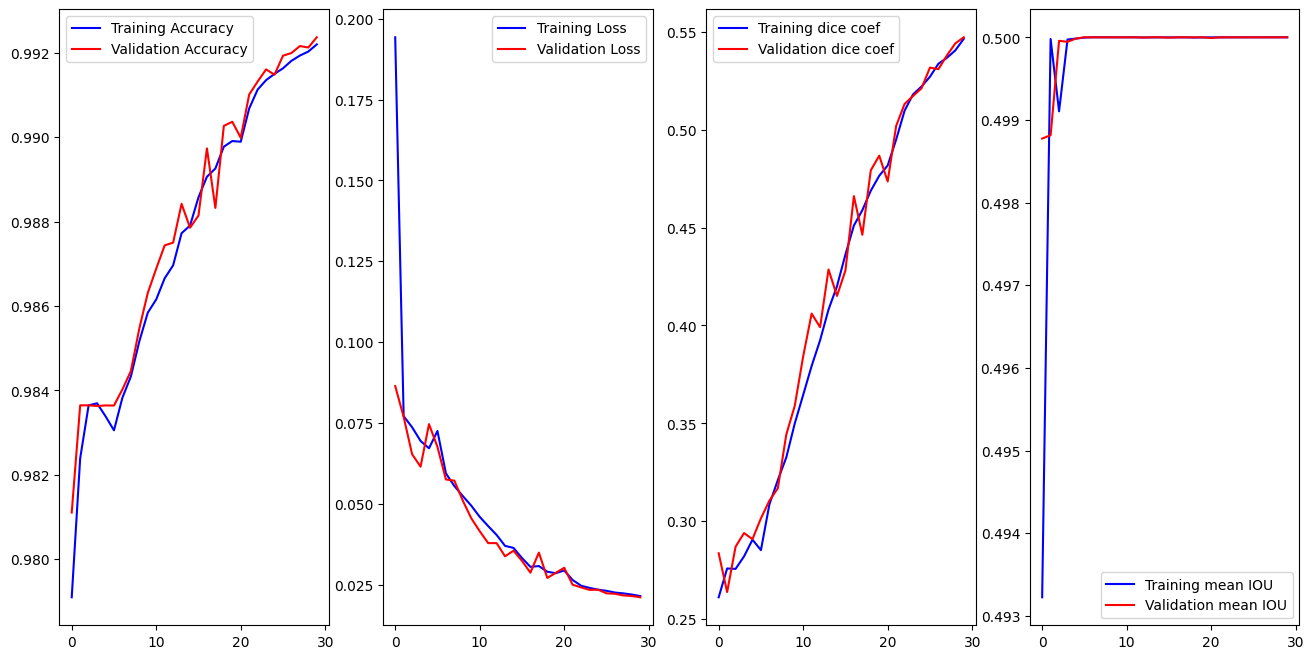

In [19]:
history = pd.read_csv('/kaggle/working/training.log', sep=',', engine='python')

hist=history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch, hist['mean_io_u'], 'b', label='Training mean IOU')
ax[3].plot(epoch, hist['val_mean_io_u'], 'r', label='Validation mean IOU')
ax[3].legend()

In [20]:
print(hist.keys())


Index(['epoch', 'accuracy', 'dice_coef', 'dice_coef_edema',
       'dice_coef_enhancing', 'dice_coef_necrotic', 'learning_rate', 'loss',
       'mean_io_u', 'precision', 'sensitivity', 'specificity', 'val_accuracy',
       'val_dice_coef', 'val_dice_coef_edema', 'val_dice_coef_enhancing',
       'val_dice_coef_necrotic', 'val_loss', 'val_mean_io_u', 'val_precision',
       'val_sensitivity', 'val_specificity'],
      dtype='object')


In [21]:

# Compile a model and load our saved weights
IMG_SIZE = 128
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

best_saved_model = build_unet(input_layer, 'he_normal', 0.2)

best_saved_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])

best_saved_model.load_weights('/kaggle/working/model.weights.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [22]:
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)

In [23]:
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] )
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

In [24]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata()


    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model.predict(X/np.max(X), verbose=1)

In [25]:
def showPredictsById(case, start_slice = 60):
    path = f"/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes predicted')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()

In [26]:
def predict_segmentation(sample_path):
    # Load NIfTI (.nii) files of the sample (patient)
    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'

    # Extract the data from these paths
    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    # Create an empty array
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    # Perform the same operations as our DataGenerator, to keep the same input shape
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    # Send our images to the CNN model and return predicted segmentation
    return model.predict(X/np.max(X), verbose=1)

In [27]:
import matplotlib.cm as cm
cmap = cm.get_cmap('viridis') 
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):
    # Choose a random patient
    random_sample = random.choice(samples_list)

    # Get path of this patient
    random_sample_path = os.path.join(TRAIN_DATASET_PATH, random_sample, random_sample)

    # Predict patient's segmentation
    predicted_seg = predict_segmentation(random_sample_path)

    # Load patient's original segmentation (Ground truth)
    seg_path = random_sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()

    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)

    # Differentiate segmentations by their labels
    all = predicted_seg[slice_to_plot,:,:,1:4] # Deletion of class 0 (Keep only Core + Edema + Enhancing classes)
    zero = predicted_seg[slice_to_plot,:,:,0] # Isolation of class 0, Background (kind of useless, it is the opposite of the "all")
    first = predicted_seg[slice_to_plot,:,:,1] # Isolation of class 1, Core
    second = predicted_seg[slice_to_plot,:,:,2] # Isolation of class 2, Edema
    third = predicted_seg[slice_to_plot,:,:,3] # Isolation of class 3, Enhancing

    # Plot Original segmentation & predicted segmentation
    print("Patient number: ", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))

    # Original segmentation
    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')

    # Layers 1, 2, 3
    axstest[1].imshow(all, cmap, norm)
    axstest[1].set_title('Predicted Segmentation - all classes')

    # Layer 0
    axstest[2].imshow(zero)
    axstest[2].set_title('Predicted Segmentation - Not Tumor')

    # Layer 1
    axstest[3].imshow(first)
    axstest[3].set_title('Predicted Segmentation - Necrotic/Core')

    # Layer 2
    axstest[4].imshow(second)
    axstest[4].set_title('Predicted Segmentation - Edema')

    # Layer 3
    axstest[5].imshow(third)
    axstest[5].set_title('Predicted Segmentation - Enhancing')

    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.show()

/tmp/ipykernel_23/427850481.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 680ms/step
Patient number:  BraTS20_Training_145


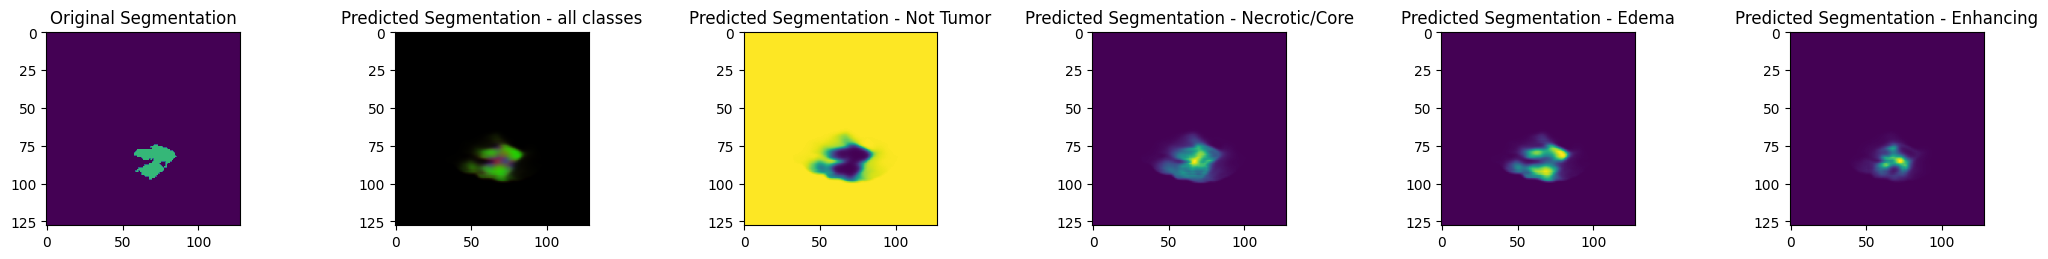

In [28]:
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)
show_predicted_segmentations(test_ids1, 60, cmap, norm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


<Figure size 640x480 with 0 Axes>

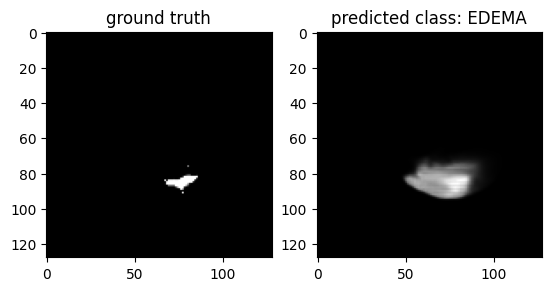

In [29]:
case = test_ids1[3][-3:]
path = f"/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)

core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]

i=40 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'

gt[gt != eval_class] = 1 # use only one class for per class evaluation

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [30]:
import gc
gc.collect()

17754

In [31]:
# Evaluate the model on the test data
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])

results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)

descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity", "Dice coef Necrotic", "Dice coef Edema", "Dice coef Enhancing"]

# Combine results list and descriptions list
results_list = zip(results, descriptions)

# Display each metric with its description
print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - accuracy: 0.9925 - dice_coef: 0.5478 - dice_coef_edema: 0.6521 - dice_coef_enhancing: 0.5913 - dice_coef_necrotic: 0.4455 - loss: 0.0209 - mean_io_u_2: 0.5208 - precision: 0.9955 - sensitivity: 0.9901 - specificity: 0.9985

Model evaluation on the test set:
Loss : 0.0211
Accuracy : 0.9924
MeanIOU : 0.5
Dice coefficient : 0.5473
Precision : 0.9954
Sensitivity : 0.9899
Specificity : 0.9985
Dice coef Necrotic : 0.4457
Dice coef Edema : 0.6576
Dice coef Enhancing : 0.5791
